# WTI COT Commercial Nowcast - TabPFN 2.5 Model Selection

This notebook evaluates TabPFN 2.5 for nowcasting WTI Commercial positions and compares it against the existing models (RF, ExtraTrees, OLS, etc.).

## TabPFN 2.5 Overview
- **TabPFN** (Tabular Prior-Data Fitted Network) is a transformer-based model pre-trained on synthetic tabular data
- It requires no hyperparameter tuning and works well on small datasets
- Version 2.5 supports regression tasks and larger datasets
- Ideal for our use case: small dataset (~800 samples), few features (3-5)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import copy

In [4]:
import sys
sys.path.append('../../../')

In [5]:
from src.settings import Settings
from src.utils.io.read import PreprocessedDataReader
from src.preprocessing.base import FutureTicker

In [6]:
from research.model_selection.CombinatorialPurgedCV import CombinatorialPurgedCV
from research.model_selection.CombinatorialPurgedCV import cpcv_predict
from research.plots import plot_bin_summary_of_xy

## Install TabPFN 2.5 (if needed)

In [7]:
# Uncomment to install TabPFN 2.5
!pip install tabpfn

  Using cached tabpfn-6.0.6-py3-none-any.whl.metadata (38 kB)
  Using cached einops-0.8.1-py3-none-any.whl.metadata (13 kB)
  Using cached pydantic_settings-2.12.0-py3-none-any.whl.metadata (3.4 kB)
  Using cached eval_type_backport-0.3.1-py3-none-any.whl.metadata (2.4 kB)
  Using cached tabpfn_common_utils-0.2.10-py3-none-any.whl.metadata (5.4 kB)
  Using cached kditransform-1.2.0-py3-none-any.whl.metadata (6.6 kB)
  Using cached posthog-6.9.3-py3-none-any.whl.metadata (6.0 kB)
  Using cached requests-2.32.5-py3-none-any.whl.metadata (4.9 kB)
  Using cached backoff-2.2.1-py3-none-any.whl.metadata (14 kB)
Using cached tabpfn-6.0.6-py3-none-any.whl (551 kB)
Using cached einops-0.8.1-py3-none-any.whl (64 kB)
Using cached eval_type_backport-0.3.1-py3-none-any.whl (6.1 kB)
Using cached kditransform-1.2.0-py3-none-any.whl (20 kB)
Using cached pydantic_settings-2.12.0-py3-none-any.whl (51 kB)
Using cached tabpfn_common_utils-0.2.10-py3-none-any.whl (34 kB)
Using cached posthog-6.9.3-py3-none

In [8]:
try:
    from tabpfn import TabPFNRegressor
    print("TabPFN imported successfully")
    TABPFN_AVAILABLE = True
except ImportError:
    print("TabPFN not installed. Please run: pip install tabpfn")
    TABPFN_AVAILABLE = False

TabPFN imported successfully


## Load Data

In [9]:
pdr = PreprocessedDataReader(Settings.historical.paths.PREPROCESSED_DATA_PATH)
dataset = pdr.read_dataset(ticker=FutureTicker.WTI)

In [10]:
print(f"Dataset shape: {dataset.shape}")
print(f"Date range: {dataset['tradeDate'].min()} to {dataset['tradeDate'].max()}")

Dataset shape: (813, 81)
Date range: 2010-01-05 to 2025-07-29


In [11]:
dataset['tradeDate'] = pd.to_datetime(dataset['tradeDate']).dt.date
dataset.sort_values(by='tradeDate', ascending=True, inplace=True)
dataset.reset_index(drop=True, inplace=True)

## Load Selected Features

In [12]:
with open("wti_cot_comm_nowcast_selected_features_by_response.json", "r") as f:
    selected_features_by_response = json.load(f)

print("Selected features by response:")
for response, features in selected_features_by_response.items():
    print(f"  {response}: {features}")

Selected features by response:
  Commercial_NetPosition_change: ['prior_cumulative_5D_F1MinusF2_Volume_change', 'prior_report_SyntheticF1MinusF2_RolledPrice_change', 'F2_RolledPrice_change']
  CommercialLongPosition_change: ['F3_RolledPrice_change', 'prior_5D_F1_OI_change', 'prior_5D_AGG_OI_change']
  CommercialShortPosition_change: ['F3_RolledPrice_change', 'prior_5D_F1_OI_change', 'prior_5D_AGG_OI_change']
  Commercial_NetPosition_to_openinterest_change: ['prior_cumulative_5D_F1MinusF2_Volume_change', 'prior_report_Commercial_NetPosition_change', 'F1_RolledPrice_change']
  CommercialLongPosition_to_openinterest_change: ['prior_report_SyntheticF1MinusF2_RolledPrice_change', 'prior_5D_F1_OI_change', 'prior_cumulative_5D_F1MinusF2_Volume_change']
  CommercialShortPosition_to_openinterest_change: ['F3_RolledPrice_change', 'prior_5D_F1_OI_change', 'prior_cumulative_5D_F1MinusF2_Volume_change']


## Load Previous Best Models (for comparison)

In [13]:
with open("wti_cot_comm_nowcast_selected_model_by_response.json", "r") as f:
    previous_best_models = json.load(f)

print("Previous best models:")
for response, model_info in previous_best_models.items():
    print(f"  {response}: {model_info['model_name']}")

Previous best models:
  Commercial_NetPosition_change: extra
  CommercialLongPosition_change: rf
  CommercialShortPosition_change: rf
  Commercial_NetPosition_to_openinterest_change: ols
  CommercialLongPosition_to_openinterest_change: rf
  CommercialShortPosition_to_openinterest_change: rf


## Define Response Variables

In [14]:
# Focus on the normalized (to_openinterest) responses for nowcasting
response_names = [
    'Commercial_NetPosition_to_openinterest_change',
    'CommercialLongPosition_to_openinterest_change',
    'CommercialShortPosition_to_openinterest_change'
]

# Also test raw position changes
response_names_raw = [
    'Commercial_NetPosition_change',
    'CommercialLongPosition_change', 
    'CommercialShortPosition_change'
]

all_response_names = response_names + response_names_raw
print(f"Testing {len(all_response_names)} response variables")

Testing 6 response variables


## Setup Cross-Validation

In [15]:
cv = CombinatorialPurgedCV(
    n_partitions=10,
    k=2,
    purge_amount=10
)
print(f"CV: {cv.n_partitions} partitions, k={cv.k}, purge={cv.purge_amount}")

CV: 10 partitions, k=2, purge=10


## Define Baseline Models

In [16]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, HistGradientBoostingRegressor

baseline_estimators = {
    "ols": LinearRegression(),
    "ridge": Ridge(alpha=1.0, random_state=42),
    "rf": RandomForestRegressor(n_estimators=250, max_depth=10, random_state=42, n_jobs=-1),
    "extra": ExtraTreesRegressor(n_estimators=250, max_depth=10, random_state=42, n_jobs=-1),
    "hgbm": HistGradientBoostingRegressor(max_iter=150, learning_rate=0.05, random_state=42),
}

## TabPFN 2.5 Setup

In [18]:
if TABPFN_AVAILABLE:
    # TabPFN 2.5 Regressor with default settings
    # Note: TabPFN works best with:
    # - Small to medium datasets (< 10,000 samples)
    # - Few features (< 100)
    # - No hyperparameter tuning needed
    
    tabpfn_regressor = TabPFNRegressor(
        n_estimators=1,  # Number of ensemble members (default)
        # device='cuda' if torch.cuda.is_available() else 'cpu',  # Uncomment if using GPU
    )
    print("TabPFN Regressor initialized")
    print(f"  n_estimators: {tabpfn_regressor.n_estimators}")
else:
    tabpfn_regressor = None
    print("TabPFN not available - skipping")

TabPFN Regressor initialized
  n_estimators: 1


## Evaluation Function

In [19]:
def evaluate_model_cpcv(estimator, X, y, cv, model_name, response_name, plot=True):
    """
    Evaluate a model using Combinatorial Purged Cross-Validation.
    Returns the correlation between predictions and actual values.
    """
    try:
        yhat = cpcv_predict(
            estimator,
            X,
            y,
            cv=cv,
            method='predict',
            n_jobs=10
        )
        
        # Calculate correlation
        corr = np.corrcoef(yhat, y)[0, 1]
        
        if plot:
            _ = plot_bin_summary_of_xy(x=yhat, y=y, k=10)
            plt.xlabel(f'{response_name} - Nowcasted')
            plt.ylabel(f'{response_name} - Actual')
            plt.grid()
            plt.title(f'CPCV Evaluation - {response_name}\n{model_name} (corr={corr:.4f})')
            plt.tight_layout()
            plt.show()
            plt.close()
        
        return corr, yhat
    
    except Exception as e:
        print(f"Error evaluating {model_name} for {response_name}: {e}")
        return np.nan, None

## Run TabPFN Evaluation

In [21]:
results = {}

for response_name in all_response_names:
    print(f"\n{'='*60}")
    print(f"Evaluating: {response_name}")
    print(f"{'='*60}")
    
    # Get features for this response
    feature_names = selected_features_by_response.get(response_name, [])
    
    if not feature_names:
        print(f"  No features found for {response_name}, skipping...")
        continue
    
    print(f"  Features: {feature_names}")
    
    # Prepare data
    Xy = dataset[['tradeDate'] + feature_names + [response_name]].dropna()
    Xy.reset_index(drop=True, inplace=True)
    
    X = Xy[feature_names].values
    y = Xy[response_name].values
    
    print(f"  Data shape: X={X.shape}, y={y.shape}")
    
    response_results = {}
    
    # Evaluate TabPFN
    if TABPFN_AVAILABLE:
        print(f"\n  Evaluating TabPFN...")
        # Create fresh instance for each response
        tabpfn = TabPFNRegressor()
        corr, yhat = evaluate_model_cpcv(
            tabpfn, 
            Xy[feature_names], 
            Xy[response_name], 
            cv, 
            'TabPFN', 
            response_name,
            plot=True
        )
        response_results['tabpfn'] = corr
        print(f"  TabPFN correlation: {corr:.4f}")
    
    # Evaluate baseline models
    for model_name, estimator in baseline_estimators.items():
        print(f"\n  Evaluating {model_name}...")
        # Create fresh instance
        estimator_copy = copy.deepcopy(estimator)
        corr, yhat = evaluate_model_cpcv(
            estimator_copy, 
            Xy[feature_names], 
            Xy[response_name], 
            cv, 
            model_name, 
            response_name,
            plot=False  # Only plot TabPFN to reduce output
        )
        response_results[model_name] = corr
        print(f"  {model_name} correlation: {corr:.4f}")
    
    results[response_name] = response_results


Evaluating: Commercial_NetPosition_to_openinterest_change
  Features: ['prior_cumulative_5D_F1MinusF2_Volume_change', 'prior_report_Commercial_NetPosition_change', 'F1_RolledPrice_change']
  Data shape: X=(799, 3), y=(799,)

  Evaluating TabPFN...
Error evaluating TabPFN for Commercial_NetPosition_to_openinterest_change: [Errno 2] No such file or directory: '/Users/oualid/Library/Caches/tabpfn/tabpfn-v2.5-regressor-v2.5_default.ckpt'
  TabPFN correlation: nan

  Evaluating ols...
  ols correlation: 0.1595

  Evaluating ridge...
  ridge correlation: 0.1595

  Evaluating rf...
  rf correlation: 0.0771

  Evaluating extra...
  extra correlation: 0.0571

  Evaluating hgbm...
  hgbm correlation: 0.0751

Evaluating: CommercialLongPosition_to_openinterest_change
  Features: ['prior_report_SyntheticF1MinusF2_RolledPrice_change', 'prior_5D_F1_OI_change', 'prior_cumulative_5D_F1MinusF2_Volume_change']
  Data shape: X=(798, 3), y=(798,)

  Evaluating TabPFN...
Error evaluating TabPFN for Commerc

Error evaluating TabPFN for CommercialShortPosition_to_openinterest_change: Authentication error downloading from 'Prior-Labs/tabpfn_2_5'.
This model is gated and requires you to accept its terms.

Please follow these steps:
1. Visit https://huggingface.co/Prior-Labs/tabpfn_2_5 in your browser and accept the terms of use.
2. Log in to your Hugging Face account via the command line by running:
   hf auth login
(Alternatively, you can set the HF_TOKEN environment variable with a read token).

For detailed instructions, see https://docs.priorlabs.ai/how-to-access-gated-models
  TabPFN correlation: nan

  Evaluating ols...


HuggingFace download failed.
For commercial usage, we provide alternative download options for v2.5, please reach out to us at sales@priorlabs.ai.
HuggingFace download failed.
For commercial usage, we provide alternative download options for v2.5, please reach out to us at sales@priorlabs.ai.
HuggingFace download failed.
For commercial usage, we provide alternative download options for v2.5, please reach out to us at sales@priorlabs.ai.
HuggingFace download failed.
For commercial usage, we provide alternative download options for v2.5, please reach out to us at sales@priorlabs.ai.
HuggingFace download failed.
For commercial usage, we provide alternative download options for v2.5, please reach out to us at sales@priorlabs.ai.
HuggingFace download failed.
For commercial usage, we provide alternative download options for v2.5, please reach out to us at sales@priorlabs.ai.


  ols correlation: 0.1146

  Evaluating ridge...
  ridge correlation: 0.1146

  Evaluating rf...


  rf correlation: 0.1098

  Evaluating extra...


  extra correlation: 0.1352

  Evaluating hgbm...


  hgbm correlation: 0.1412

Evaluating: Commercial_NetPosition_change
  Features: ['prior_cumulative_5D_F1MinusF2_Volume_change', 'prior_report_SyntheticF1MinusF2_RolledPrice_change', 'F2_RolledPrice_change']
  Data shape: X=(798, 3), y=(798,)

  Evaluating TabPFN...


Error evaluating TabPFN for Commercial_NetPosition_change: Authentication error downloading from 'Prior-Labs/tabpfn_2_5'.
This model is gated and requires you to accept its terms.

Please follow these steps:
1. Visit https://huggingface.co/Prior-Labs/tabpfn_2_5 in your browser and accept the terms of use.
2. Log in to your Hugging Face account via the command line by running:
   hf auth login
(Alternatively, you can set the HF_TOKEN environment variable with a read token).

For detailed instructions, see https://docs.priorlabs.ai/how-to-access-gated-models
  TabPFN correlation: nan

  Evaluating ols...


HuggingFace download failed.
For commercial usage, we provide alternative download options for v2.5, please reach out to us at sales@priorlabs.ai.
HuggingFace download failed.
For commercial usage, we provide alternative download options for v2.5, please reach out to us at sales@priorlabs.ai.
HuggingFace download failed.
HuggingFace download failed.
For commercial usage, we provide alternative download options for v2.5, please reach out to us at sales@priorlabs.ai.
For commercial usage, we provide alternative download options for v2.5, please reach out to us at sales@priorlabs.ai.
HuggingFace download failed.
For commercial usage, we provide alternative download options for v2.5, please reach out to us at sales@priorlabs.ai.
HuggingFace download failed.
For commercial usage, we provide alternative download options for v2.5, please reach out to us at sales@priorlabs.ai.


  ols correlation: 0.1201

  Evaluating ridge...
  ridge correlation: 0.1201

  Evaluating rf...


  rf correlation: 0.0708

  Evaluating extra...


  extra correlation: 0.0292

  Evaluating hgbm...


  hgbm correlation: 0.0930

Evaluating: CommercialLongPosition_change
  Features: ['F3_RolledPrice_change', 'prior_5D_F1_OI_change', 'prior_5D_AGG_OI_change']
  Data shape: X=(800, 3), y=(800,)

  Evaluating TabPFN...


Error evaluating TabPFN for CommercialLongPosition_change: Authentication error downloading from 'Prior-Labs/tabpfn_2_5'.
This model is gated and requires you to accept its terms.

Please follow these steps:
1. Visit https://huggingface.co/Prior-Labs/tabpfn_2_5 in your browser and accept the terms of use.
2. Log in to your Hugging Face account via the command line by running:
   hf auth login
(Alternatively, you can set the HF_TOKEN environment variable with a read token).

For detailed instructions, see https://docs.priorlabs.ai/how-to-access-gated-models
  TabPFN correlation: nan

  Evaluating ols...


HuggingFace download failed.
For commercial usage, we provide alternative download options for v2.5, please reach out to us at sales@priorlabs.ai.


  ols correlation: 0.6851

  Evaluating ridge...
  ridge correlation: 0.6851

  Evaluating rf...


  rf correlation: 0.6657

  Evaluating extra...


  extra correlation: 0.6685

  Evaluating hgbm...


  hgbm correlation: 0.6632

Evaluating: CommercialShortPosition_change
  Features: ['F3_RolledPrice_change', 'prior_5D_F1_OI_change', 'prior_5D_AGG_OI_change']
  Data shape: X=(800, 3), y=(800,)

  Evaluating TabPFN...


Error evaluating TabPFN for CommercialShortPosition_change: Authentication error downloading from 'Prior-Labs/tabpfn_2_5'.
This model is gated and requires you to accept its terms.

Please follow these steps:
1. Visit https://huggingface.co/Prior-Labs/tabpfn_2_5 in your browser and accept the terms of use.
2. Log in to your Hugging Face account via the command line by running:
   hf auth login
(Alternatively, you can set the HF_TOKEN environment variable with a read token).

For detailed instructions, see https://docs.priorlabs.ai/how-to-access-gated-models
  TabPFN correlation: nan

  Evaluating ols...


HuggingFace download failed.
For commercial usage, we provide alternative download options for v2.5, please reach out to us at sales@priorlabs.ai.


  ols correlation: 0.6843

  Evaluating ridge...
  ridge correlation: 0.6843

  Evaluating rf...


  rf correlation: 0.6555

  Evaluating extra...


  extra correlation: 0.6529

  Evaluating hgbm...


  hgbm correlation: 0.6533


## Results Summary

In [20]:
# Create results DataFrame
results_df = pd.DataFrame(results).T
results_df = results_df.round(4)

print("\n" + "="*80)
print("MODEL COMPARISON - CPCV Correlation Scores")
print("="*80)
print(results_df.to_string())


MODEL COMPARISON - CPCV Correlation Scores
                                                tabpfn     ols   ridge      rf   extra    hgbm
Commercial_NetPosition_to_openinterest_change      NaN  0.1595  0.1595  0.0771  0.0571  0.0751
CommercialLongPosition_to_openinterest_change      NaN  0.1198  0.1198  0.1965  0.2006  0.1623
CommercialShortPosition_to_openinterest_change     NaN  0.1146  0.1146  0.1098  0.1352  0.1412
Commercial_NetPosition_change                      NaN  0.1201  0.1201  0.0708  0.0292  0.0930
CommercialLongPosition_change                      NaN  0.6851  0.6851  0.6657  0.6685  0.6632
CommercialShortPosition_change                     NaN  0.6843  0.6843  0.6555  0.6529  0.6533


In [21]:
# Highlight best model per response
print("\n" + "="*80)
print("BEST MODEL PER RESPONSE")
print("="*80)

for response in results_df.index:
    best_model = results_df.loc[response].idxmax()
    best_score = results_df.loc[response].max()
    tabpfn_score = results_df.loc[response].get('tabpfn', np.nan)
    
    is_tabpfn_best = best_model == 'tabpfn'
    marker = "***" if is_tabpfn_best else ""
    
    print(f"{response}:")
    print(f"  Best: {best_model} ({best_score:.4f}) {marker}")
    if not np.isnan(tabpfn_score) and not is_tabpfn_best:
        diff = best_score - tabpfn_score
        print(f"  TabPFN: {tabpfn_score:.4f} (diff: {diff:+.4f})")


BEST MODEL PER RESPONSE
Commercial_NetPosition_to_openinterest_change:
  Best: ols (0.1595) 
CommercialLongPosition_to_openinterest_change:
  Best: extra (0.2006) 
CommercialShortPosition_to_openinterest_change:
  Best: hgbm (0.1412) 
Commercial_NetPosition_change:
  Best: ols (0.1201) 
CommercialLongPosition_change:
  Best: ols (0.6851) 
CommercialShortPosition_change:
  Best: ols (0.6843) 


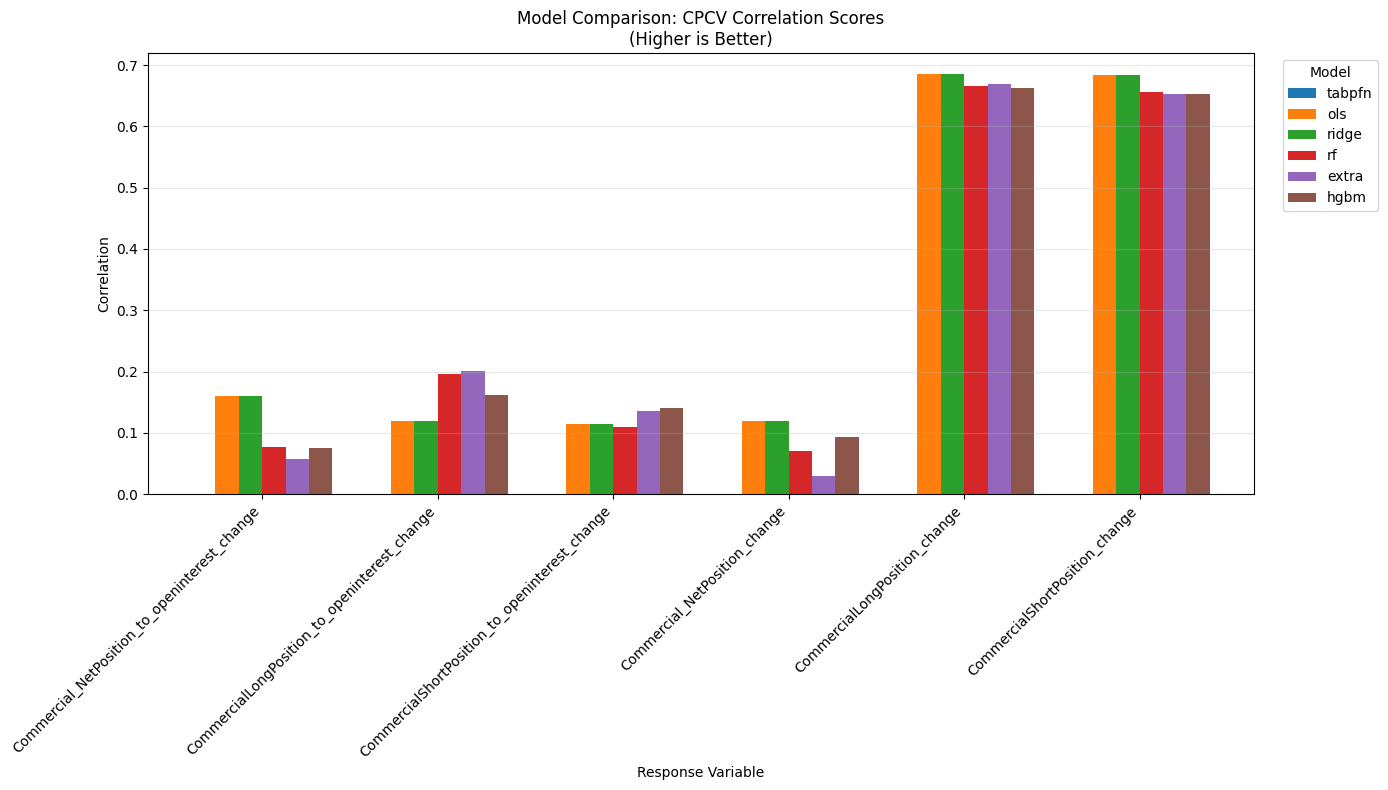

In [22]:
# Visualization: Model comparison bar chart
if len(results_df) > 0:
    fig, ax = plt.subplots(figsize=(14, 8))
    
    results_df.plot(kind='bar', ax=ax, width=0.8)
    
    ax.set_ylabel('Correlation')
    ax.set_xlabel('Response Variable')
    ax.set_title('Model Comparison: CPCV Correlation Scores\n(Higher is Better)')
    ax.legend(title='Model', bbox_to_anchor=(1.02, 1), loc='upper left')
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax.grid(axis='y', alpha=0.3)
    
    # Rotate x labels for readability
    plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()

## TabPFN with Different Configurations

Testing TabPFN with different n_estimators...
  n_estimators=1...


Error evaluating TabPFN (n=1) for Commercial_NetPosition_to_openinterest_change: Authentication error downloading from 'Prior-Labs/tabpfn_2_5'.
This model is gated and requires you to accept its terms.

Please follow these steps:
1. Visit https://huggingface.co/Prior-Labs/tabpfn_2_5 in your browser and accept the terms of use.
2. Log in to your Hugging Face account via the command line by running:
   hf auth login
(Alternatively, you can set the HF_TOKEN environment variable with a read token).

For detailed instructions, see https://docs.priorlabs.ai/how-to-access-gated-models
    Correlation: nan
  n_estimators=4...


HuggingFace download failed.
For commercial usage, we provide alternative download options for v2.5, please reach out to us at sales@priorlabs.ai.
HuggingFace download failed.
For commercial usage, we provide alternative download options for v2.5, please reach out to us at sales@priorlabs.ai.
HuggingFace download failed.
For commercial usage, we provide alternative download options for v2.5, please reach out to us at sales@priorlabs.ai.
HuggingFace download failed.
For commercial usage, we provide alternative download options for v2.5, please reach out to us at sales@priorlabs.ai.


Error evaluating TabPFN (n=4) for Commercial_NetPosition_to_openinterest_change: Authentication error downloading from 'Prior-Labs/tabpfn_2_5'.
This model is gated and requires you to accept its terms.

Please follow these steps:
1. Visit https://huggingface.co/Prior-Labs/tabpfn_2_5 in your browser and accept the terms of use.
2. Log in to your Hugging Face account via the command line by running:
   hf auth login
(Alternatively, you can set the HF_TOKEN environment variable with a read token).

For detailed instructions, see https://docs.priorlabs.ai/how-to-access-gated-models
    Correlation: nan
  n_estimators=8...


HuggingFace download failed.
For commercial usage, we provide alternative download options for v2.5, please reach out to us at sales@priorlabs.ai.


Error evaluating TabPFN (n=8) for Commercial_NetPosition_to_openinterest_change: Authentication error downloading from 'Prior-Labs/tabpfn_2_5'.
This model is gated and requires you to accept its terms.

Please follow these steps:
1. Visit https://huggingface.co/Prior-Labs/tabpfn_2_5 in your browser and accept the terms of use.
2. Log in to your Hugging Face account via the command line by running:
   hf auth login
(Alternatively, you can set the HF_TOKEN environment variable with a read token).

For detailed instructions, see https://docs.priorlabs.ai/how-to-access-gated-models
    Correlation: nan
  n_estimators=16...


HuggingFace download failed.
For commercial usage, we provide alternative download options for v2.5, please reach out to us at sales@priorlabs.ai.
HuggingFace download failed.
For commercial usage, we provide alternative download options for v2.5, please reach out to us at sales@priorlabs.ai.
HuggingFace download failed.
For commercial usage, we provide alternative download options for v2.5, please reach out to us at sales@priorlabs.ai.
HuggingFace download failed.
For commercial usage, we provide alternative download options for v2.5, please reach out to us at sales@priorlabs.ai.


Error evaluating TabPFN (n=16) for Commercial_NetPosition_to_openinterest_change: Authentication error downloading from 'Prior-Labs/tabpfn_2_5'.
This model is gated and requires you to accept its terms.

Please follow these steps:
1. Visit https://huggingface.co/Prior-Labs/tabpfn_2_5 in your browser and accept the terms of use.
2. Log in to your Hugging Face account via the command line by running:
   hf auth login
(Alternatively, you can set the HF_TOKEN environment variable with a read token).

For detailed instructions, see https://docs.priorlabs.ai/how-to-access-gated-models
    Correlation: nan
  n_estimators=32...


HuggingFace download failed.
For commercial usage, we provide alternative download options for v2.5, please reach out to us at sales@priorlabs.ai.


Error evaluating TabPFN (n=32) for Commercial_NetPosition_to_openinterest_change: Authentication error downloading from 'Prior-Labs/tabpfn_2_5'.
This model is gated and requires you to accept its terms.

Please follow these steps:
1. Visit https://huggingface.co/Prior-Labs/tabpfn_2_5 in your browser and accept the terms of use.
2. Log in to your Hugging Face account via the command line by running:
   hf auth login
(Alternatively, you can set the HF_TOKEN environment variable with a read token).

For detailed instructions, see https://docs.priorlabs.ai/how-to-access-gated-models
    Correlation: nan


HuggingFace download failed.
For commercial usage, we provide alternative download options for v2.5, please reach out to us at sales@priorlabs.ai.
HuggingFace download failed.
For commercial usage, we provide alternative download options for v2.5, please reach out to us at sales@priorlabs.ai.


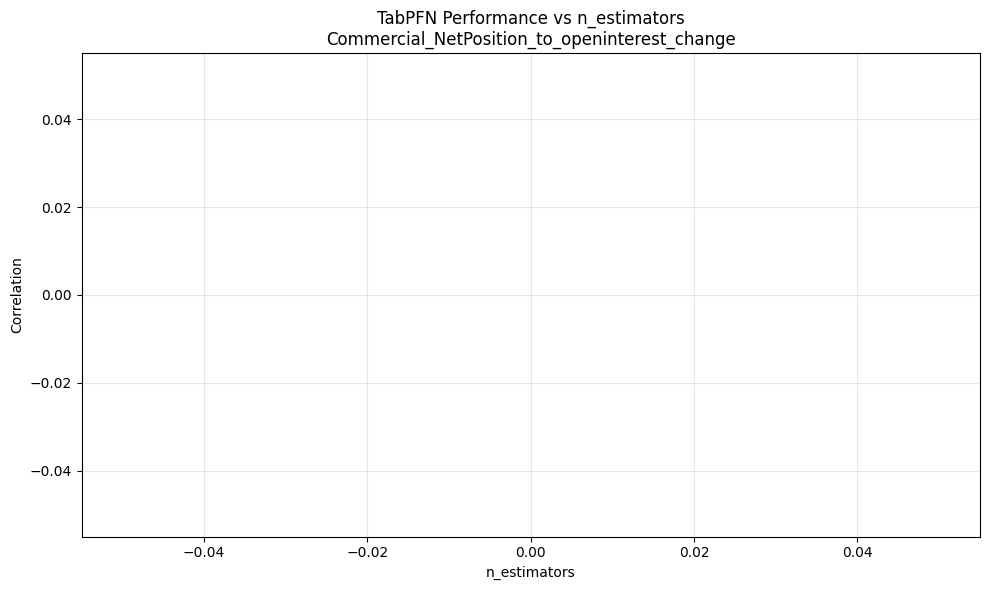

In [23]:
if TABPFN_AVAILABLE:
    print("Testing TabPFN with different n_estimators...")
    
    # Test response
    test_response = 'Commercial_NetPosition_to_openinterest_change'
    feature_names = selected_features_by_response.get(test_response, [])
    
    if feature_names:
        Xy = dataset[['tradeDate'] + feature_names + [test_response]].dropna()
        Xy.reset_index(drop=True, inplace=True)
        
        n_estimator_options = [1, 4, 8, 16, 32]
        tabpfn_results = {}
        
        for n_est in n_estimator_options:
            print(f"  n_estimators={n_est}...")
            tabpfn = TabPFNRegressor(n_estimators=n_est)
            corr, _ = evaluate_model_cpcv(
                tabpfn,
                Xy[feature_names],
                Xy[test_response],
                cv,
                f'TabPFN (n={n_est})',
                test_response,
                plot=False
            )
            tabpfn_results[n_est] = corr
            print(f"    Correlation: {corr:.4f}")
        
        # Plot results
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.plot(list(tabpfn_results.keys()), list(tabpfn_results.values()), 'bo-', linewidth=2, markersize=8)
        ax.set_xlabel('n_estimators')
        ax.set_ylabel('Correlation')
        ax.set_title(f'TabPFN Performance vs n_estimators\n{test_response}')
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

## Save Results

In [24]:
# Save results to JSON
results_dict = results_df.to_dict()

with open("wti_cot_comm_nowcast_tabpfn_comparison.json", "w") as f:
    json.dump(results_dict, f, indent=2)

print("Results saved to wti_cot_comm_nowcast_tabpfn_comparison.json")

Results saved to wti_cot_comm_nowcast_tabpfn_comparison.json


In [25]:
# Determine best model including TabPFN
final_best_models = {}

for response in results_df.index:
    best_model = results_df.loc[response].idxmax()
    best_score = results_df.loc[response].max()
    
    final_best_models[response] = {
        'model_name': best_model,
        'score': float(best_score)
    }

print("\nFinal Best Models (including TabPFN):")
for response, info in final_best_models.items():
    print(f"  {response}: {info['model_name']} ({info['score']:.4f})")


Final Best Models (including TabPFN):
  Commercial_NetPosition_to_openinterest_change: ols (0.1595)
  CommercialLongPosition_to_openinterest_change: extra (0.2006)
  CommercialShortPosition_to_openinterest_change: hgbm (0.1412)
  Commercial_NetPosition_change: ols (0.1201)
  CommercialLongPosition_change: ols (0.6851)
  CommercialShortPosition_change: ols (0.6843)


## Summary & Conclusions

In [26]:
print("="*80)
print("SUMMARY: TabPFN 2.5 Evaluation for WTI COT Commercial Nowcasting")
print("="*80)

if TABPFN_AVAILABLE and 'tabpfn' in results_df.columns:
    # Count wins
    tabpfn_wins = sum(results_df.idxmax(axis=1) == 'tabpfn')
    total_responses = len(results_df)
    
    print(f"\nTabPFN Performance:")
    print(f"  - Best model for {tabpfn_wins}/{total_responses} responses")
    print(f"  - Average correlation: {results_df['tabpfn'].mean():.4f}")
    print(f"  - Max correlation: {results_df['tabpfn'].max():.4f}")
    print(f"  - Min correlation: {results_df['tabpfn'].min():.4f}")
    
    # Compare to best baseline
    baseline_cols = [c for c in results_df.columns if c != 'tabpfn']
    if baseline_cols:
        best_baseline_avg = results_df[baseline_cols].max(axis=1).mean()
        tabpfn_avg = results_df['tabpfn'].mean()
        
        print(f"\nComparison to Best Baseline:")
        print(f"  - TabPFN avg: {tabpfn_avg:.4f}")
        print(f"  - Best baseline avg: {best_baseline_avg:.4f}")
        print(f"  - Difference: {tabpfn_avg - best_baseline_avg:+.4f}")
else:
    print("\nTabPFN was not available or did not run successfully.")

print("\n" + "="*80)

SUMMARY: TabPFN 2.5 Evaluation for WTI COT Commercial Nowcasting

TabPFN Performance:
  - Best model for 0/6 responses
  - Average correlation: nan
  - Max correlation: nan
  - Min correlation: nan

Comparison to Best Baseline:
  - TabPFN avg: nan
  - Best baseline avg: 0.3318
  - Difference: +nan

